In [76]:
from glm.glmnet import ElasticNet, GLMNet
from glm.families import Gaussian, Bernoulli
import numpy as np

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

%matplotlib inline
import matplotlib.pyplot as plt

plt.style.use('ggplot')

In [77]:
X = np.empty(shape=(100000, 7))
X[:, 0] = 1.0
X[:, 1] = np.random.normal(size=100000)
X[:, 2] = np.random.normal(size=100000)
X[:, 3] = np.random.normal(size=100000)
X[:, 4] = np.random.normal(size=100000)
X[:, 5] = np.random.normal(size=100000)


#y = 1 + 0.05*X[:, 1] + np.random.normal(scale=0.2, size=100000)
y = 1 + 0.5*X[:, 1] - 0.75*X[:, 2] + 2*X[:, 3] - 1.0*X[:, 4] + 1.0*X[:, 5] + np.random.normal(scale=0.2, size=100000)

s = StandardScaler()
X = s.fit_transform(X)
X[:, 0] = 1.0

In [78]:
lambdas = np.logspace(np.log10(0.000001), np.log10(50))

In [82]:
enets = []
for lam in lambdas:
    enet = ElasticNet(lam=lam, alpha=0.2)
    enet.fit(X, y)
    enets.append(enet.coef_)

In [83]:
coef_paths = np.row_stack(enets)

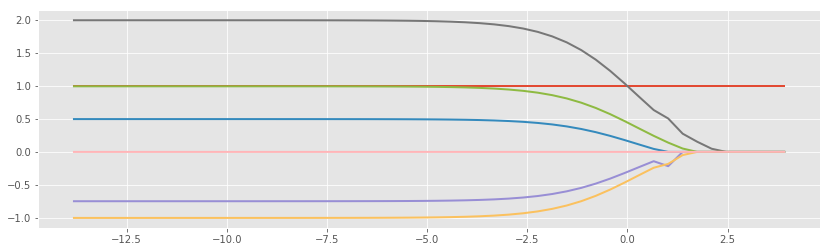

In [84]:
fig, ax = plt.subplots(figsize=(14, 4))

t = np.log(lambdas)
for idx in range(coef_paths.shape[1]):
    ax.plot(t, coef_paths[:, idx])

In [11]:
enet.predict(X)

array([ 1.00209814,  1.00209814,  1.00209814, ...,  1.00209814,
        1.00209814,  1.00209814])

## GlmNet

In [26]:
X = np.empty(shape=(100000, 7))
X[:, 0] = 1.0
X[:, 1] = np.random.normal(size=100000)
X[:, 2] = np.random.normal(size=100000)
X[:, 3] = np.random.normal(size=100000)
X[:, 4] = np.random.normal(size=100000)
X[:, 5] = np.random.normal(size=100000)

y = 1 + 0.5*X[:, 1] - 0.75*X[:, 2] + 2*X[:, 3] - 1.0*X[:, 4] + 1.0*X[:, 5] + np.random.normal(scale=0.2, size=100000)

s = StandardScaler()
X = s.fit_transform(X)
X[:, 0] = 1.0

In [27]:
lambdas = np.logspace(np.log10(0.00001), np.log10(10000), num=50)
lambdas = lambdas[::-1]

In [28]:
gnet = GLMNet(family=Gaussian(), alpha=1.0, lambdas=lambdas, max_iter=50)
gnet.fit(X, y)

In [29]:
gnet._enets[-1][-1].coef_

array([ 1.0026085 ,  0.50017758, -0.75620406,  2.01304704, -1.00102346,
       -1.51653806])

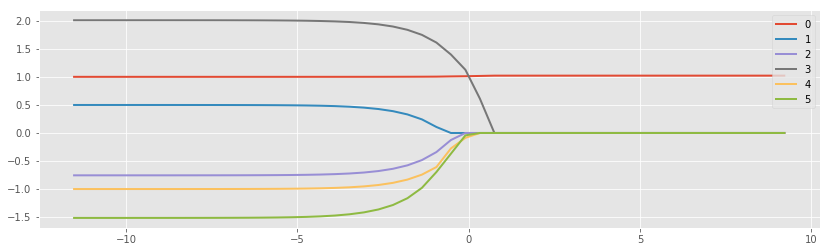

In [30]:
coef_paths = np.row_stack([[g.coef_ for g in enets][-1] for enets in gnet._enets])

fig, ax = plt.subplots(figsize=(14, 4))

t = np.log(lambdas)
for idx in range(0, coef_paths.shape[1]):
     ax.plot(t, coef_paths[:, idx], label=str(idx))
ax.legend()

In [31]:
lr = LinearRegression()
lr.fit(X, y)
lr.coef_

array([ 0.  ,  0.5 , -0.75,  2.  , -1.  , -1.  ])

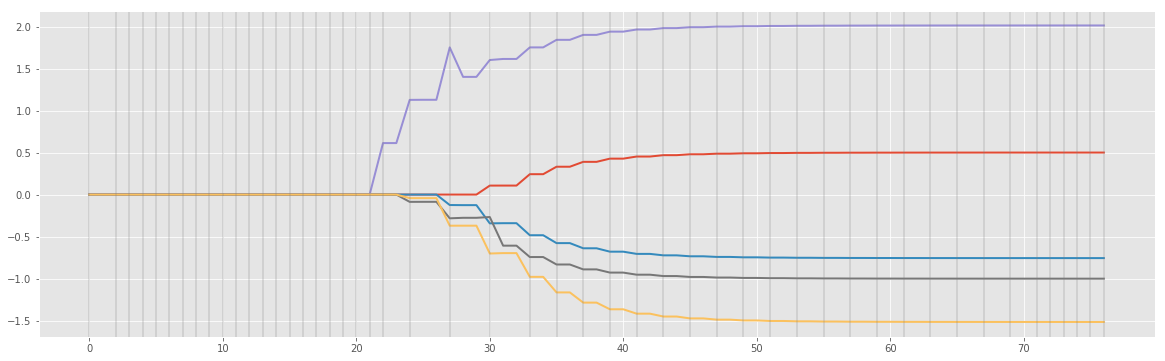

In [32]:
granular_paths = [np.row_stack([g.coef_ for g in enet_list]) for enet_list in gnet._enets]
quad_approx_boundaries = np.cumsum([0] + [path.shape[0] for path in granular_paths])
long_coef_path = np.row_stack(granular_paths)

fig, ax = plt.subplots(figsize=(20, 6))
t = np.arange(long_coef_path.shape[0])
for idx in range(1, long_coef_path.shape[1]):
    ax.plot(t, long_coef_path[:, idx])
    
for boundary in quad_approx_boundaries[:-1]:
    ax.axvline(x=boundary, ymin=0, ymax=1, color="grey", alpha=0.2)

In [33]:
gnet._enets[0][0]._coef_path

[array([ 1.02385402,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ]),
 array([ 1.02385402,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ])]

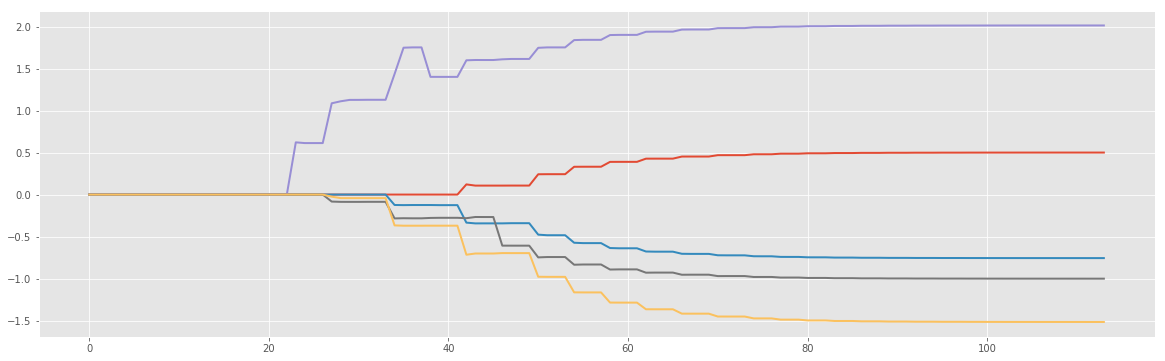

In [34]:
long_coef_path = np.row_stack([np.row_stack([e._coef_path for e in enet_list]) for enet_list in gnet._enets])

fig, ax = plt.subplots(figsize=(20, 6))
t = np.arange(long_coef_path.shape[0])
for idx in range(1, long_coef_path.shape[1]):
    ax.plot(t, long_coef_path[:, idx])

## Logit Net

In [21]:
X = np.empty(shape=(100000, 6))
X[:, 0] = 1.0
X[:, 1] = np.random.normal(size=100000)
X[:, 2] = np.random.normal(size=100000)
X[:, 3] = 0.25*X[:, 1] + np.sqrt(1 - 0.25**2)*np.random.normal(size=100000)
X[:, 4] = 0.25*X[:, 1] + np.sqrt(1 - 0.25**2)*np.random.normal(size=100000)
#X[:, 3] = np.random.normal(size=100000)
#X[:, 4] = np.random.normal(size=100000)
X[:, 5] = np.random.normal(size=100000)

lp = 0.05*X[:, 1] - 0.1*X[:, 2] -0.1*X[:, 3] + 0.075*X[:, 5]
p = 1 / (1 + np.exp(-lp))
y = np.random.binomial(1, p=p, size=100000)

In [22]:
#s = StandardScaler()
#X = s.fit_transform(X)
#X[:, 0] = 1.0

In [23]:
lambdas = np.logspace(np.log10(0.000001), np.log10(0.2), num=50)
lambdas = lambdas[::-1]

gnet = GLMNet(family=Bernoulli(), alpha=0.2, lambdas=lambdas)
gnet.fit(X, y)

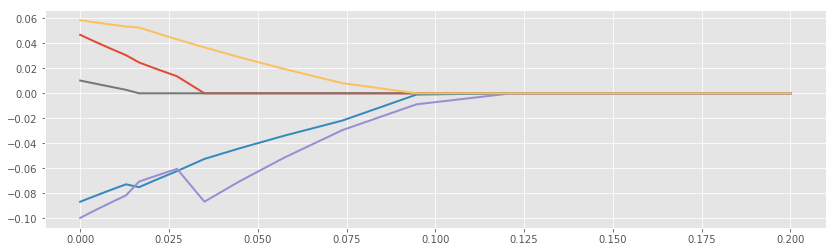

In [24]:
coef_paths = np.row_stack([[g.coef_ for g in enets][-1] for enets in gnet._enets])

fig, ax = plt.subplots(figsize=(14, 4))

t = lambdas
for idx in range(1, coef_paths.shape[1]):
     ax.plot(t, coef_paths[:, idx])

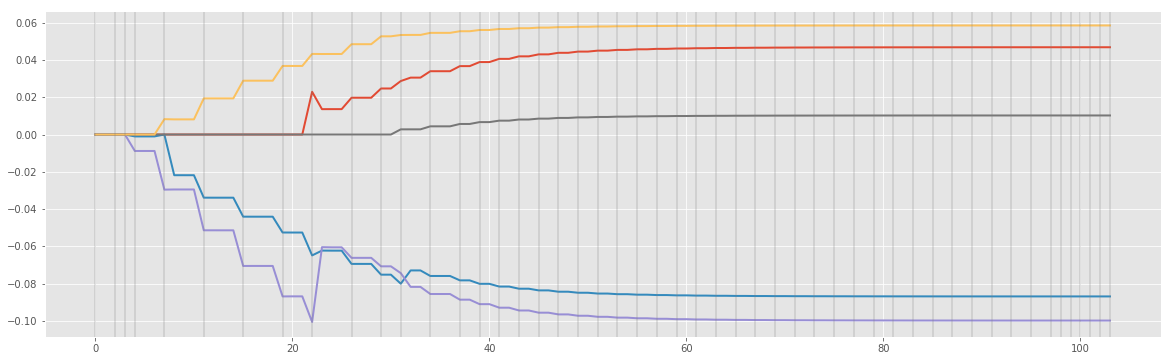

In [25]:
granular_paths = [np.row_stack([g.coef_ for g in enet_list]) for enet_list in gnet._enets]
quad_approx_boundaries = np.cumsum([0] + [path.shape[0] for path in granular_paths])
long_coef_path = np.row_stack(granular_paths)

fig, ax = plt.subplots(figsize=(20, 6))
t = np.arange(long_coef_path.shape[0])
for idx in range(1, long_coef_path.shape[1]):
    ax.plot(t, long_coef_path[:, idx])
    
for boundary in quad_approx_boundaries[:-1]:
    ax.axvline(x=boundary, ymin=0, ymax=1, color="grey", alpha=0.2)